In [67]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, split, when, countDistinct, max, desc, hour
from pyspark.sql.window import Window
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import builtins

# create SparkSession
spark = SparkSession.builder \
    .appName("eCommerce_behavior_data_analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.heartbeatInterval", "900s") \
    .config("spark.network.timeout", "1000s") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

In [2]:
df = spark.read.csv("hdfs://localhost:9000/user/michaeliayang/2019-Oct.csv", header=True, inferSchema=True)

# Show first 5 lines
df.show(5)

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [3]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [4]:
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print('Missing Values:')
missing_values.show()

Missing Values:
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [8]:
duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")
duplicates.show(10)

Number of Duplicates: 18099
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|count|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|2019-10-01 16:44:59|      cart|   1801806|2053013554415534427|electronics.video.tv|  artel| 124.4|551484167|cbea1412-7f08-476...|    4|
|2019-10-01 10:32:16|      view|   2600519|2053013563970159485|                NULL| gefest|166.28|555549288|35785d30-1ba0-44b...|    2|
|2019-10-02 05:03:10|      cart|  30000074|2127425436764865054|construction.tool...|eurolux| 99.62|535333026|f492aac9-9ce1-4ba...|    2|
|2019-10-02 10:42:47|      cart|   1004767|2053013555631882655|electronics.smart...|samsung|253.05|543076049|5f099d9f-bd48-40d...|    2|
|2019-10-02 1

In [9]:
df = df.dropDuplicates()
duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")

Number of Duplicates: 0


In [20]:
event_type = df.select('event_type').distinct()
event_type.show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



# Global Convension Rate Analysis

In [19]:
# calculate the global conversion rate
global_funnel = df.groupBy("event_type").agg(count("*").alias("event_count"))

total_views = global_funnel.filter(col("event_type") == "view").select("event_count").collect()[0][0]
total_carts = global_funnel.filter(col("event_type") == "cart").select("event_count").collect()[0][0]
total_purchases = global_funnel.filter(col("event_type") == "purchase").select("event_count").collect()[0][0]

view_to_cart_rate = total_carts / total_views
cart_to_purchase_rate = total_purchases / total_carts
overall_conversion_rate = total_purchases / total_views

print(f"View to Cart Rate: {view_to_cart_rate:.2%}")
print(f"Cart to Purchase Rate: {cart_to_purchase_rate:.2%}")
print(f"Overall Conversion Rate: {overall_conversion_rate:.2%}")

View to Cart Rate: 2.20%
Cart to Purchase Rate: 82.67%
Overall Conversion Rate: 1.82%


# Category Convension Rate Analysis

In [23]:
df_categories = df.withColumn("category_main", split(col("category_code"), r"\.").getItem(0))
    
df_no_nulls = df_categories.filter(col("category_code").isNotNull())

# Check if main categories are correctly extracted
df_no_nulls.select("category_code", "category_main").show(10)

+--------------------+-------------+
|       category_code|category_main|
+--------------------+-------------+
|electronics.audio...|  electronics|
|construction.tool...| construction|
|electronics.smart...|  electronics|
|appliances.kitche...|   appliances|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|  electronics.clocks|  electronics|
+--------------------+-------------+
only showing top 10 rows



In [45]:
category_main_count = df_no_nulls.groupBy("category_main").agg(countDistinct("product_id").alias("product_count"))
category_main_count.show()

# calculate total products
total_products = df_no_nulls.select(countDistinct("product_id")).collect()[0][0]

# calculate the ratio of each product
category_main_ratio = category_main_count.withColumn("product_ratio", col("product_count") / total_products)

category_main_ratio.show()

+-------------+-------------+
|category_main|product_count|
+-------------+-------------+
|     medicine|           29|
|    computers|         7930|
|         auto|         1201|
|   stationery|          607|
|        sport|         2157|
|      apparel|        13417|
|   appliances|        12362|
| country_yard|          185|
|    furniture|         6972|
|  accessories|         2516|
|         kids|         5123|
|  electronics|        14950|
| construction|         5701|
+-------------+-------------+

+-------------+-------------+--------------------+
|category_main|product_count|       product_ratio|
+-------------+-------------+--------------------+
|     medicine|           29|3.964456596035543...|
|    computers|         7930| 0.10840738209159262|
|         auto|         1201|0.016418318523581683|
|   stationery|          607|0.008298017771701981|
|        sport|         2157|0.029487354750512645|
|      apparel|        13417| 0.18341763499658237|
|   appliances|        12362| 

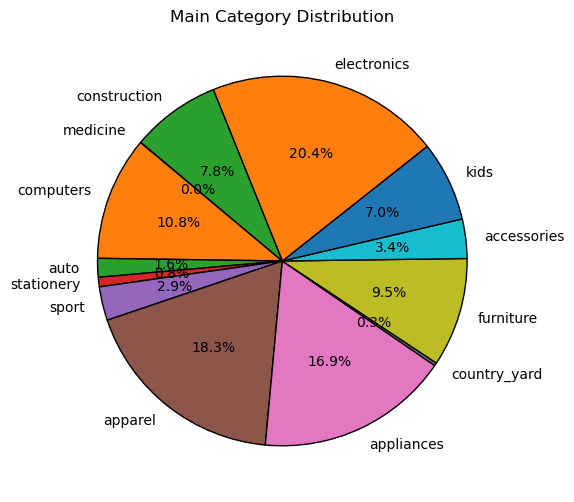

In [77]:
category_main_ratio_pd = category_main_ratio.toPandas()

mainCat_names = category_main_ratio_pd["category_main"]
mainCat_values = category_main_ratio_pd["product_ratio"]

plt.figure(figsize=(6, 6))
plt.pie(mainCat_values, labels=mainCat_names, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Main Category Distribution")
plt.show()

In [85]:
category_funnel = df_no_nulls.groupBy("category_main", "event_type").agg(countDistinct("product_id").alias("product_count"))
category_funnel.show(10)

window_spec = Window.partitionBy("category_main")
category_conversion = category_funnel.withColumn("total_views", sum(col("product_count")).over(window_spec)) \
    .filter(col("event_type") == "purchase") \
    .withColumn("conversion_rate", col("product_count") / col("total_views")) \
    .select("category_main", "conversion_rate")

category_conversion.show(10)

+-------------+----------+-------------+
|category_main|event_type|product_count|
+-------------+----------+-------------+
|   appliances|  purchase|         4838|
|   stationery|      cart|           34|
|        sport|  purchase|          270|
| construction|  purchase|          939|
|   appliances|      cart|         2852|
|         auto|      cart|          167|
|    furniture|      cart|          218|
|  accessories|  purchase|          554|
|  electronics|  purchase|         4698|
|    computers|      cart|         1285|
+-------------+----------+-------------+
only showing top 10 rows

+-------------+-------------------+
|category_main|    conversion_rate|
+-------------+-------------------+
|  accessories|0.17399497487437185|
|      apparel|0.15754154907494514|
|   appliances| 0.2412726910033912|
|         auto|0.30804248861911987|
|    computers|0.22255968953007677|
| construction| 0.1347782402755849|
| country_yard|0.13063063063063063|
|  electronics|0.21801475706529305|
|   

# Brand Conversion Rate Analysis

In [26]:
bins = [0, 50, 100, 200, 500, 1000, float("inf")]
labels = ["0-50", "50-100", "100-200", "200-500", "500-1000", "1000+"]

df_with_bins = df.withColumn(
    "price_bin",
    when(col("price").between(bins[0], bins[1]), labels[0])
    .when(col("price").between(bins[1], bins[2]), labels[1])
    .when(col("price").between(bins[2], bins[3]), labels[2])
    .when(col("price").between(bins[3], bins[4]), labels[3])
    .when(col("price").between(bins[4], bins[5]), labels[4])
    .otherwise(labels[5])
)

price_distribution = df_with_bins.groupBy("price_bin").agg(
    countDistinct("product_id").alias("product_count")
).orderBy("price_bin")

price_distribution.show()

+---------+-------------+
|price_bin|product_count|
+---------+-------------+
|     0-50|        77696|
|  100-200|        29952|
|    1000+|         4806|
|  200-500|        25504|
|   50-100|        32782|
| 500-1000|         9428|
+---------+-------------+



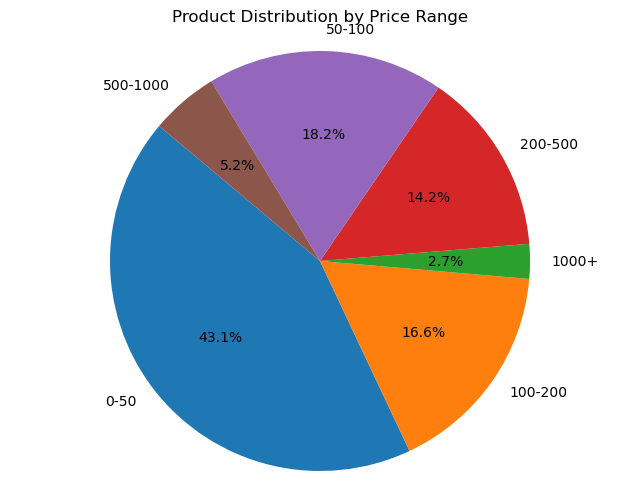

In [32]:
price_distribution_pd = price_distribution.toPandas()

plt.figure(figsize=(8, 6))
plt.pie(
    price_distribution_pd["product_count"],
    labels=price_distribution_pd["price_bin"],
    autopct="%1.1f%%",
    startangle=140,
    textprops={"fontsize": 10}
)
plt.title("Product Distribution by Price Range")
plt.axis("equal")
plt.show()

In [16]:
top_brands = df.filter(col("event_type") == "purchase") \
    .groupBy("brand") \
    .agg(
        count("*").alias("total_purchases") 
    ) \
    .filter(col("brand").isNotNull()) \
    .orderBy(desc("total_purchases")) \
    .limit(20)

top_brands.show(truncate=False)

+--------+---------------+
|brand   |total_purchases|
+--------+---------------+
|samsung |172878         |
|apple   |142858         |
|xiaomi  |56609          |
|huawei  |23499          |
|lucente |11576          |
|oppo    |10887          |
|cordiant|10551          |
|lg      |8725           |
|acer    |6880           |
|sony    |6729           |
|elenberg|6189           |
|artel   |6123           |
|triangle|5835           |
|bosch   |5705           |
|indesit |5024           |
|nokian  |4907           |
|lenovo  |4578           |
|philips |4461           |
|vitek   |4106           |
|redmond |4002           |
+--------+---------------+



In [22]:
brand_performance = df.filter(col("brand").isNotNull()).groupBy("brand").agg(
    count("*").alias("total_events"),
    count(col("event_type")).alias("total_views"), 
    sum((col("event_type") == "purchase").cast("int")).alias("total_purchases")
)

brand_performance = brand_performance.withColumn(
    "conversion_rate", 
    col("total_purchases") / col("total_views")
)

top_sellers = brand_performance.orderBy(col("total_purchases").desc()).limit(20)
top_sellers.show(truncate=False)

+--------+------------+-----------+---------------+--------------------+
|brand   |total_events|total_views|total_purchases|conversion_rate     |
+--------+------------+-----------+---------------+--------------------+
|samsung |5271172     |5271172    |172878         |0.03279688084547421 |
|apple   |4116981     |4116981    |142858         |0.03469969863839546 |
|xiaomi  |3080998     |3080998    |56609          |0.01837359193352284 |
|huawei  |1109758     |1109758    |23499          |0.021174886777117173|
|lucente |655818      |655818     |11576          |0.017651238605832717|
|oppo    |482131      |482131     |10887          |0.022580999769772115|
|cordiant|368045      |368045     |10551          |0.028667690092244156|
|lg      |561883      |561883     |8725           |0.01552814375946594 |
|acer    |427882      |427882     |6880           |0.016079199405443556|
|sony    |456429      |456429     |6729           |0.014742709161775435|
|elenberg|248001      |248001     |6189           |

In [36]:
top_brands_list = [row["brand"] for row in top_brands.select("brand").collect()]

df_top_brands = df.filter(col("brand").isin(top_brands_list)) \
    .select("brand", "product_id", "price") \
    .dropDuplicates(["brand", "product_id"])

df_top_brands.show()

+--------+----------+-------+
|   brand|product_id|  price|
+--------+----------+-------+
|  huawei|   1004709| 155.77|
|triangle|  12711589|  50.97|
| redmond|   3300349|  64.09|
| samsung|   3601214|  540.3|
| redmond|   3300488| 100.36|
|  huawei|   1003815| 772.19|
| samsung|   1201513| 926.35|
|   vitek|   3701187|  51.46|
|   apple|  18000780|  74.62|
|    sony|  13000174|  71.79|
|    acer|   1305092| 514.79|
| samsung|  18001328|  15.16|
|   apple|  18001356|  12.84|
| samsung|  18001199|   1.69|
|triangle|  12717675|  60.23|
| philips|   1801508|  334.6|
| samsung|   4500360| 346.39|
|   apple|  18001330| 198.18|
|  nokian|  12706779| 200.78|
|    sony|   2200870|1544.18|
+--------+----------+-------+
only showing top 20 rows



In [38]:
df_with_bins_brand = df_top_brands.withColumn(
    "price_bin",
    when(col("price").between(bins[0], bins[1]), labels[0])
    .when(col("price").between(bins[1], bins[2]), labels[1])
    .when(col("price").between(bins[2], bins[3]), labels[2])
    .when(col("price").between(bins[3], bins[4]), labels[3])
    .when(col("price").between(bins[4], bins[5]), labels[4])
    .otherwise(labels[5])
)

price_distribution_brand = df_with_bins_brand.groupBy("price_bin").agg(
    countDistinct("product_id").alias("product_count")
).orderBy("price_bin")

price_distribution_brand.show()

+---------+-------------+
|price_bin|product_count|
+---------+-------------+
|     0-50|         2458|
|  100-200|         2017|
|    1000+|          716|
|  200-500|         2190|
|   50-100|         1858|
| 500-1000|         1149|
+---------+-------------+



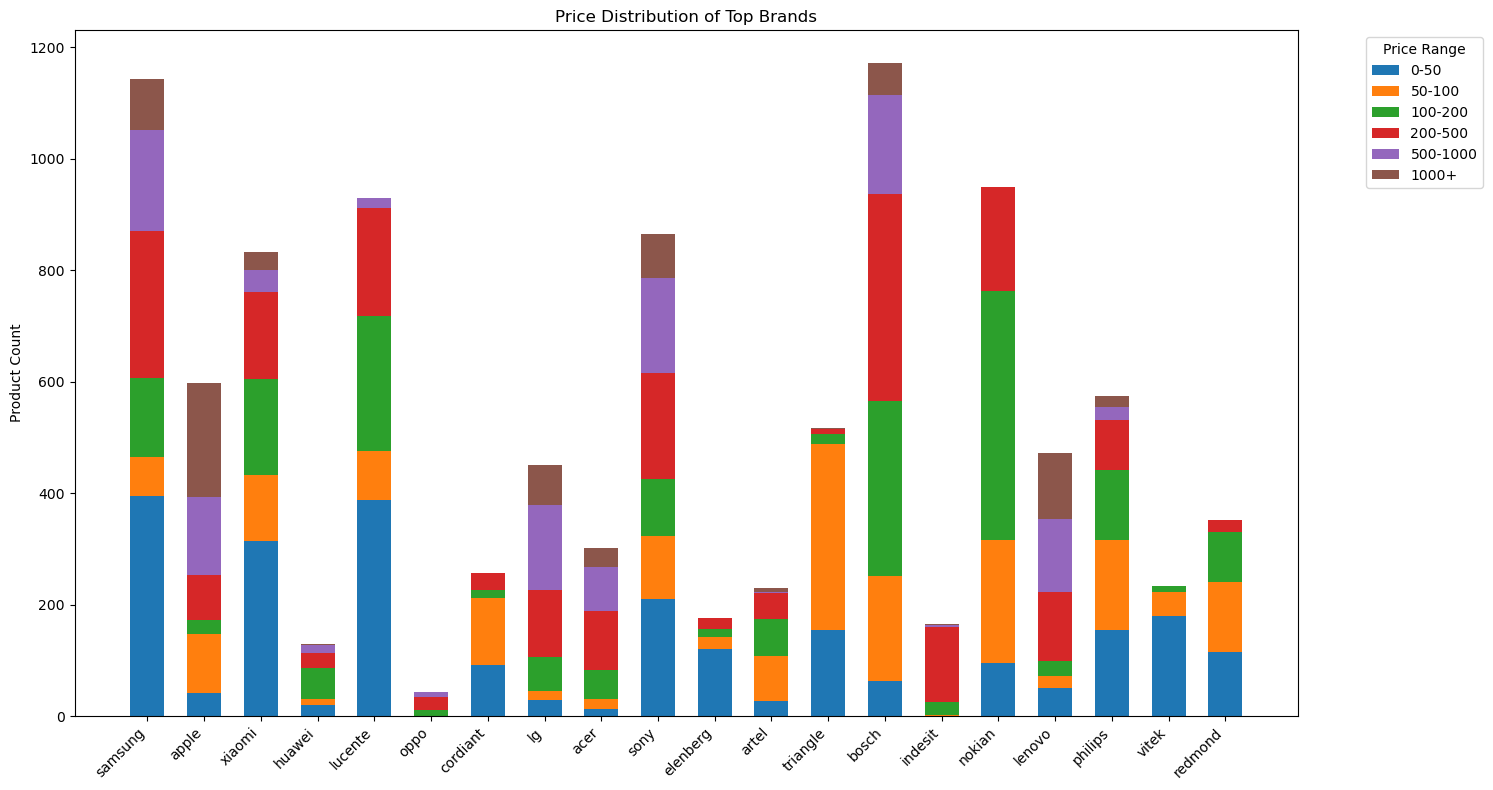

In [44]:
brands = top_brands_list
bins = labels 
bin_counts = {brand: [] for brand in brands}

for brand in brands:
    for bin_label in bins:
        count = df_with_bins_brand.filter(
            (col("brand") == brand) & (col("price_bin") == bin_label)
        ).select("product_id").distinct().count()
        bin_counts[brand].append(count)

fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.6
x = np.arange(len(brands))

bottom = np.zeros(len(brands))
for idx, bin_label in enumerate(bins):
    counts = [bin_counts[brand][idx] for brand in brands]
    ax.bar(x, counts, bar_width, label=bin_label, bottom=bottom)
    bottom += counts

ax.set_xticks(x)
ax.set_xticklabels(brands, rotation=45, ha="right")
ax.set_ylabel("Product Count")
ax.set_title("Price Distribution of Top Brands")
ax.legend(title="Price Range", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [58]:
brand_best_bins = {}

for brand in brands:
    total_products = builtins.sum(bin_counts[brand])
    if total_products == 0:
        continue
    
    conversion_rates = [bin_counts[brand][idx] / total_products for idx in range(len(bins))]
    
    max_idx = np.argmax(conversion_rates) 
    best_bin = bins[max_idx] 
    best_rate = conversion_rates[max_idx] 
    
    brand_best_bins[brand] = (best_bin, best_rate)

for brand, (best_bin, best_rate) in brand_best_bins.items():
    print(f"Brand {brand} has the highest conversion rate in the {best_bin} price range: {best_rate:.2%}")

Brand samsung has the highest conversion rate in the 0-50 price range: 34.47%
Brand apple has the highest conversion rate in the 1000+ price range: 34.17%
Brand xiaomi has the highest conversion rate in the 0-50 price range: 37.74%
Brand huawei has the highest conversion rate in the 100-200 price range: 42.64%
Brand lucente has the highest conversion rate in the 0-50 price range: 41.77%
Brand oppo has the highest conversion rate in the 200-500 price range: 53.49%
Brand cordiant has the highest conversion rate in the 50-100 price range: 47.08%
Brand lg has the highest conversion rate in the 500-1000 price range: 33.70%
Brand acer has the highest conversion rate in the 200-500 price range: 34.77%
Brand sony has the highest conversion rate in the 0-50 price range: 24.28%
Brand elenberg has the highest conversion rate in the 0-50 price range: 68.18%
Brand artel has the highest conversion rate in the 50-100 price range: 35.37%
Brand triangle has the highest conversion rate in the 50-100 pri

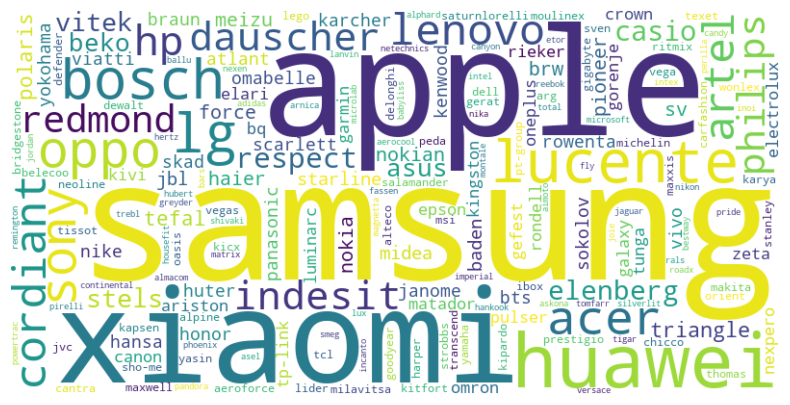

In [64]:
brand_frequencies = {
    row["brand"]: row["count"]
    for row in df.filter(col("brand").isNotNull()).groupBy("brand").count().collect()
}

wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(brand_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

# User Habit Analysis

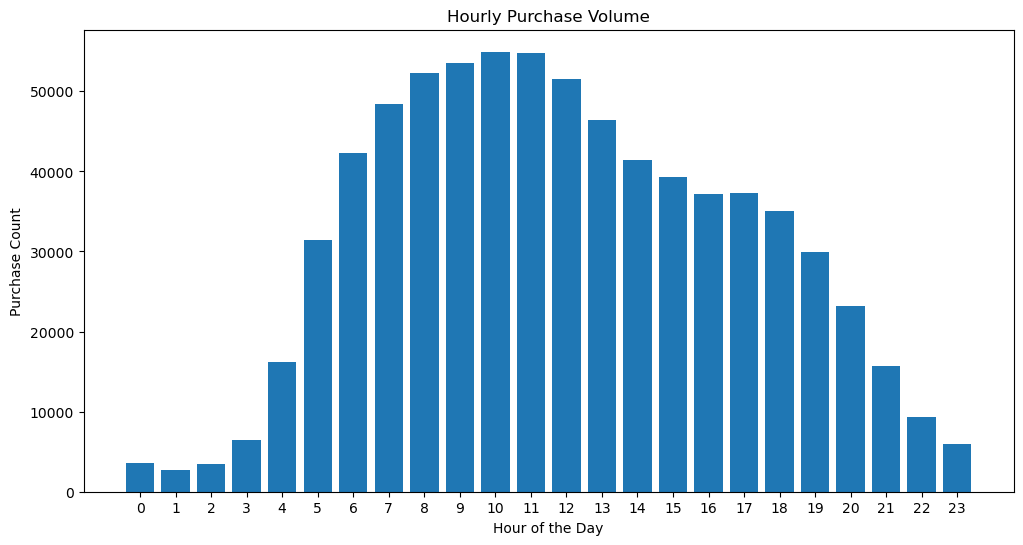

In [73]:
hourly_purchases = df.filter(col("event_type") == "purchase") \
    .groupBy(hour("event_time").alias("hour")) \
    .agg(count("*").alias("purchase_count")) \
    .orderBy("hour")

hourly_purchases_pd = hourly_purchases.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(hourly_purchases_pd["hour"], hourly_purchases_pd["purchase_count"])
plt.xlabel("Hour of the Day")
plt.ylabel("Purchase Count")
plt.title("Hourly Purchase Volume")
plt.xticks(range(24))
plt.show()

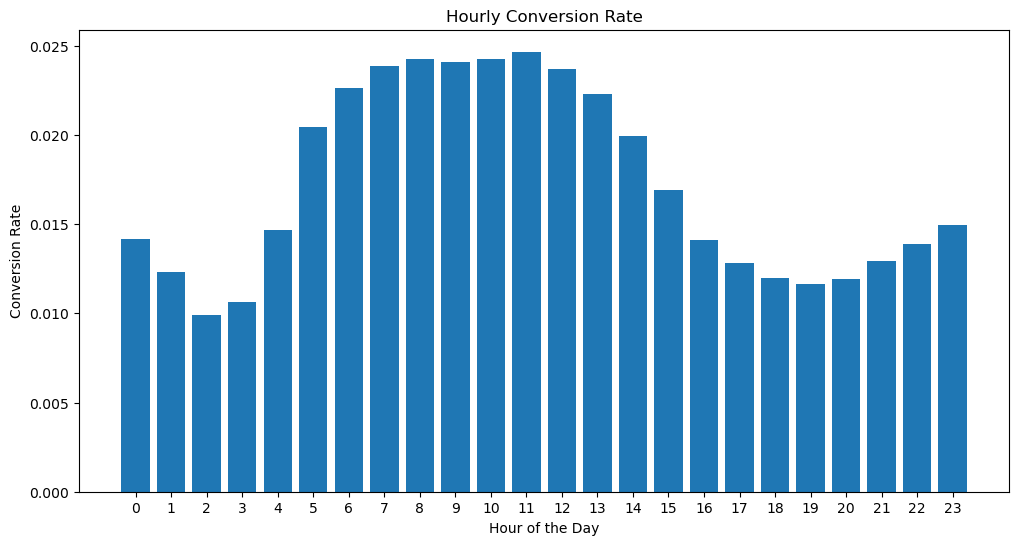

In [75]:
hourly_events = df.groupBy(hour("event_time").alias("hour")).agg(
    sum((col("event_type") == "view").cast("int")).alias("total_views"),
    sum((col("event_type") == "purchase").cast("int")).alias("total_purchases")
)

hourly_conversion = hourly_events.withColumn(
    "conversion_rate", 
    col("total_purchases") / col("total_views")
).orderBy("hour")

hourly_conversion_pd = hourly_conversion.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(hourly_conversion_pd["hour"], hourly_conversion_pd["conversion_rate"])
plt.xlabel("Hour of the Day")
plt.ylabel("Conversion Rate")
plt.title("Hourly Conversion Rate")
plt.xticks(range(24))
plt.show()